In [78]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
from matplotlib.pyplot import cm

from helpers.synthesis_plots import *

plt.style.use("science.mplstyle")

dpi = 800

In [79]:
results_dir = "/clusterfs/ml4hep/rrmastandrea/oversampling_results_8_2_32_10/"

n_sig_inj = [1000]
seeds = [x for x in range(20)]
largest_factor = 6




# Load in


In [80]:
#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(0.00001, 1, 100)

keys = [x for x in range(largest_factor+1)]

rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}     
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}


for n in n_sig_inj:
    
    for seed in seeds:
        
        
        for k in keys:
      
            if k == 0:
                iid = "feta"
            else:
                iid = f"feta_o{k}"

            tpr, sic, rejection, maxsic = get_sic_rejection(iid, seed, n, results_dir)    
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(maxsic)
            

# Take the avg

In [81]:
med_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_max_sics_dict = {k:[[],[],[]] for k in keys} # mean, std
    

for n in n_sig_inj:
    
    for k in keys:
        
        med_rejections_dict[k][n] = get_med_percentile(rejections_dict[k][n])
        med_sics_dict[k][n] = get_med_percentile(sics_dict[k][n])
        
        med_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        med_max_sics_dict[k][1].append(np.percentile(max_sics_dict[k][n], 16))
        med_max_sics_dict[k][2].append(np.percentile(max_sics_dict[k][n], 84))
        

for k in keys:
    med_max_sics_dict[k][0] = np.array(med_max_sics_dict[k][0])
    med_max_sics_dict[k][1] = np.array(med_max_sics_dict[k][1])
    med_max_sics_dict[k][2] = np.array(med_max_sics_dict[k][2])
    


In [82]:
n_to_plot = [1000]

l = 3
f_1 = 20
f_2 = 30

num_bkg = 121339

# SIC

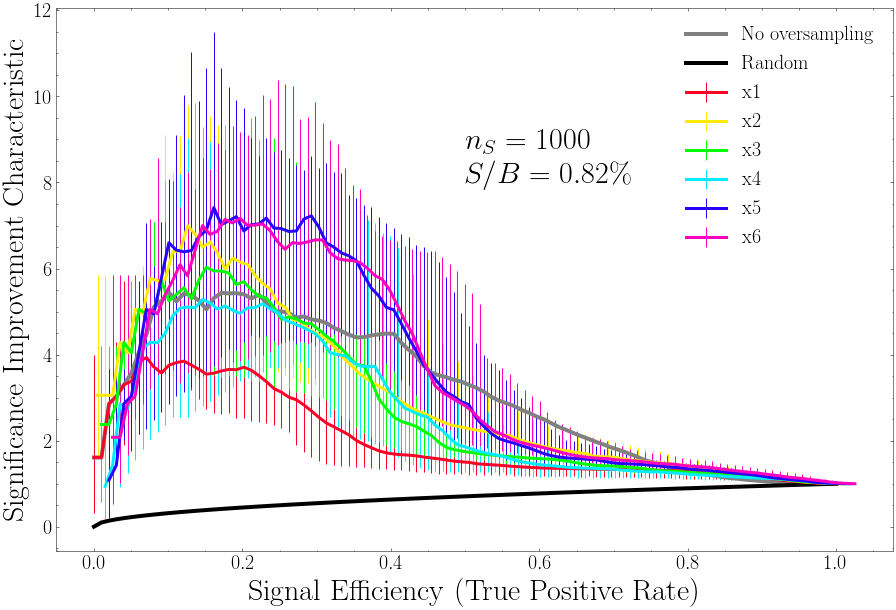

In [90]:
color = iter(cm.gist_rainbow(np.linspace(0, 1, largest_factor)))
eps = 0


    
for n in n_to_plot:
    
    fig = plt.figure(figsize = (15, 10))


    for k in range(largest_factor+1):
        
        if k == 0:
            label = "No oversampling"
            c = "grey"
            plt.plot(x_axis, med_sics_dict[k][n][0], label = label, color = c, linewidth = l+1)
            #plt.errorbar(x_axis+eps, med_sics_dict[k][n][0], yerr = [med_sics_dict[k][n][0]-med_sics_dict[k][n][1],med_sics_dict[k][n][2]-med_sics_dict[k][n][0]], label = label, 
                         #color = c, linewidth = l, elinewidth = l-2)
        else: 
            c = next(color)
            label = f"x{k}"
       
            plt.errorbar(x_axis+eps, med_sics_dict[k][n][0], yerr = [med_sics_dict[k][n][0]-med_sics_dict[k][n][1],med_sics_dict[k][n][2]-med_sics_dict[k][n][0]], label = label, 
                         color = c, linewidth = l, elinewidth = l-2)
            eps += 0.005


        """
        plt.plot(x_axis, mean_sics_dict[k][n][0], label = label, color = c, linewidth = l+1)
        if k != 0:
            plt.fill_between(x_axis, mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                             mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                             alpha = 0.3, color = c, linewidth = 0)
        """
     
    

    plt.text(0.5, 8, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)
    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)

    #plt.ylim(-0.5, 3.5)
    
    #get handles and labels
    #handles, labels = plt.gca().get_legend_handles_labels()
    #specify order of items in legend
    #order = [0, 2, 3, 4, 5, 6, 7, 1]
    plt.legend(fontsize = f_1)
    
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    #plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/oversampling_sic_{n}.pdf", dpi = dpi)
    
    plt.show()

# Rejection

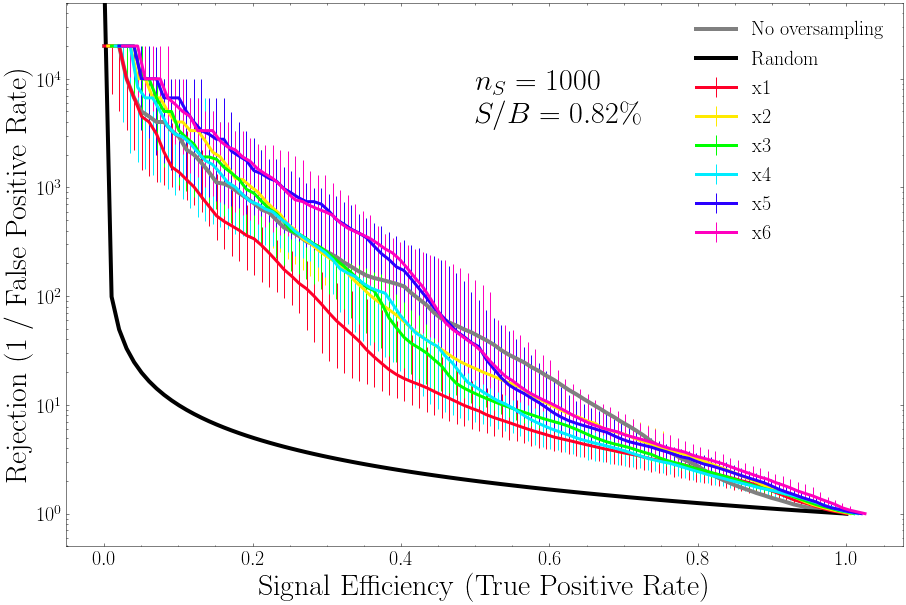

In [88]:
color = iter(cm.gist_rainbow(np.linspace(0, 1, largest_factor)))
eps = 0
fig = plt.figure(figsize = (15, 10))

for n in n_to_plot:


    for k in range(largest_factor+1):
        
        if k == 0:
            label = "No oversampling"
            c = "grey"
            plt.plot(x_axis, med_rejections_dict[k][n][0], label = label, color = c, linewidth = l+1)
            #plt.errorbar(x_axis+eps, med_rejections_dict[k][n][0], yerr = [med_rejections_dict[k][n][0]-med_rejections_dict[k][n][1],med_rejections_dict[k][n][2]-med_rejections_dict[k][n][0]], label = label, 
                     #    color = c, linewidth = l, elinewidth = l-2)
        else: 
            c = next(color)
            label = f"x{k}"
       
            plt.errorbar(x_axis+eps, med_rejections_dict[k][n][0], yerr = [med_rejections_dict[k][n][0]-med_rejections_dict[k][n][1],med_rejections_dict[k][n][2]-med_rejections_dict[k][n][0]], label = label, 
                         color = c, linewidth = l, elinewidth = l-2)
            eps += 0.005

    plt.plot(x_axis, 1.0/x_axis, label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 4000, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    #specify order of items in legend
    order = [0, 2, 3, 4, 5, 6, 7, 1]
    plt.legend( fontsize = f_1)
    
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"paper_plots/oversampling_rej_{n}.pdf", dpi = dpi)

    plt.show()

## SIC vs rej

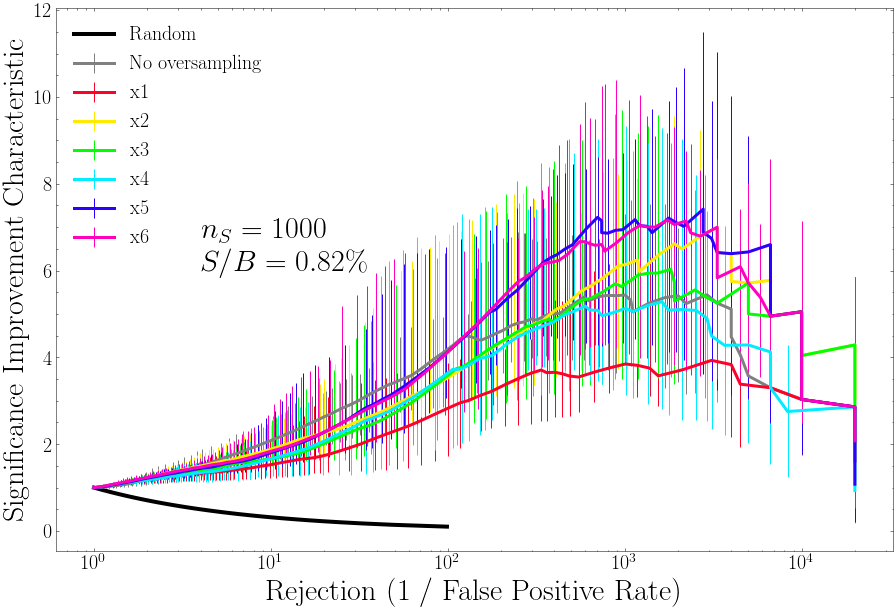

In [85]:

color = iter(cm.gist_rainbow(np.linspace(0, 1, largest_factor)))
eps = 0
fig = plt.figure(figsize = (15, 10))

for n in n_to_plot:

    for k in range(largest_factor+1):
        
        if k == 0:
            label = "No oversampling"
            c = "grey"
            plt.errorbar(med_rejections_dict[k][n][0]+eps, med_sics_dict[k][n][0], yerr = [med_sics_dict[k][n][0]-med_sics_dict[k][n][1],med_sics_dict[k][n][2]-med_sics_dict[k][n][0]], label = label, 
                         color = c, linewidth = l, elinewidth = l-2)
            #plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], label = label, color = c, linewidth = l+1)
        else: 
            c = next(color)
            label = f"x{k}"
                   
            plt.errorbar(med_rejections_dict[k][n][0]+eps, med_sics_dict[k][n][0], yerr = [med_sics_dict[k][n][0]-med_sics_dict[k][n][1],med_sics_dict[k][n][2]-med_sics_dict[k][n][0]], label = label, 
                         color = c, linewidth = l, elinewidth = l-2)
            eps += 0
            
    
    
    plt.plot(1.0/x_axis[1:], x_axis[1:]/np.sqrt(x_axis)[1:], label = "Random", color = "black", linewidth = l+1)
    
    plt.text(4, 6, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    #specify order of items in legend
    order = [0, 2, 3, 4, 5, 6, 7, 1]
    plt.legend( fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"paper_plots/oversampling_sic_vs_rej_{n}.pdf", dpi = dpi)
    


    plt.show()